In [3]:
import tensorflow as tf
# from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import *
import keras


In [27]:
def FCNs(h, w, NUM_CLASSES, s = '32'):
    input_layer = Input(shape=(h, w, 3))
    
    # VGG Model backbone with pre-trained ImageNet weights.
    vgg_model = keras.applications.vgg19.VGG19(include_top=False, weights=None, input_shape = (h,w,3), classes=NUM_CLASSES)
    
    # Extracting different outputs from same model
    fcn_backbone = Model(
        inputs=vgg_model.layers[1].input,
        outputs=[
            vgg_model.get_layer(block_name).output
            for block_name in ["block3_pool", "block4_pool", "block5_pool"]
        ],
    )
    
    # Setting backbone to be non-trainable
    fcn_backbone.trainable = True
    
    x = fcn_backbone(input_layer)
    
    # Converting Dense layers to Conv2D layers
    units = [4096, 4096]
    dense_convs = []
    
    for filter_idx in range(len(units)):
        dense_conv = Conv2D(
            filters=units[filter_idx],
            kernel_size=(7, 7) if filter_idx == 0 else (1, 1),
            strides=(1, 1),
            activation="relu",
            padding="same",
            use_bias=False)
        dense_convs.append(dense_conv)
        # dropout_layer = keras.layers.Dropout(0.5)
        # dense_convs.append(dense_convs)
    
    dense_convs = keras.Sequential(dense_convs)
    dense_convs.trainable = True
    
    x[-1] = dense_convs(x[-1])
    
    pool3_output, pool4_output, pool5_output = x


    # 1x1 convolution to set channels = number of classes
    pool5 = keras.layers.Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        padding="same",
        strides=(1, 1),
        activation="relu",
    )
    
    # Get Softmax outputs for all classes
    fcn32s_conv_layer = keras.layers.Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        activation="softmax",
        padding="same",
        strides=(1, 1),
    )
    
    # Up-sample to original image size
    fcn32s_upsampling = keras.layers.UpSampling2D(
        size=(32, 32),
        data_format=keras.backend.image_data_format(),
        interpolation="bilinear",
    )
    
    final_fcn32s_pool = pool5(pool5_output)
    final_fcn32s_output = fcn32s_conv_layer(final_fcn32s_pool)
    final_fcn32s_output = fcn32s_upsampling(final_fcn32s_output)
    
    fcns_model = keras.Model(inputs=input_layer, outputs=final_fcn32s_output)


    if s=='16' or s=='8':
        # 1x1 convolution to set channels = number of classes
        # Followed from the original Caffe implementation
        pool4 = Conv2D(
            filters=NUM_CLASSES,
            kernel_size=(1, 1),
            padding="same",
            strides=(1, 1),
            activation="linear",
            kernel_initializer=keras.initializers.Zeros(),
        )(pool4_output)
        
        # Intermediate up-sample
        pool5 =UpSampling2D(
            size=(2, 2),
            interpolation="bilinear",
        )(final_fcn32s_pool)
        
        # Get Softmax outputs for all classes
        fcn16s_conv_layer = Conv2D(
            filters=NUM_CLASSES,
            kernel_size=(1, 1),
            activation="sigmoid",
            padding="same",
            strides=(1, 1),
        )
        
        # Up-sample to original image size
        fcn16s_upsample_layer = UpSampling2D(
            size=(16, 16),
            interpolation="bilinear",
        )
        
        # Add intermediate outputs
        final_fcn16s_pool = Add()([pool4, pool5])
        final_fcn16s_output = fcn16s_conv_layer(final_fcn16s_pool)
        final_fcn16s_output = fcn16s_upsample_layer(final_fcn16s_output)
        
        fcns_model = Model(inputs=input_layer, outputs=final_fcn16s_output)

    if s=='8':
        pool3 = Conv2D(
        filters=NUM_CLASSES,
        kernel_size=(1, 1),
        padding="same",
        strides=(1, 1),
        activation="linear",
        kernel_initializer=keras.initializers.Zeros(),
    )(pool3_output)
    
        # Intermediate up-sample
        intermediate_pool_output = UpSampling2D(
            size=(2, 2),
            interpolation="bilinear",
        )(final_fcn16s_pool)
        
        # Get Softmax outputs for all classes
        fcn8s_conv_layer = Conv2D(
            filters=NUM_CLASSES,
            kernel_size=(1, 1),
            activation="sigmoid",
            padding="same",
            strides=(1, 1),
        )
        
        # Up-sample to original image size
        fcn8s_upsample_layer = keras.layers.UpSampling2D(
            size=(8, 8),
            interpolation="bilinear",
        )
        
        # Add intermediate outputs
        final_fcn8s_pool = Add()([pool3, intermediate_pool_output])
        final_fcn8s_output = fcn8s_conv_layer(final_fcn8s_pool)
        final_fcn8s_output = fcn8s_upsample_layer(final_fcn8s_output)
        
        fcns_model = keras.models.Model(inputs=input_layer, outputs=final_fcn8s_output)

    fcns_model.compile(optimizer = Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics =['accuracy','mse','mae'])
    return fcns_model

In [28]:
def unet(pretrained_weights = None,input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(3, 1, activation = 'relu')(conv9)

    model = keras.models.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate=1e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [10]:
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask


In [11]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [13]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

2025-07-17 17:45:04.778051: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-17 17:45:05.002944: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-17 17:45:05.006012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Dataset oxford_iiit_pet downloaded and prepared to /home/icuh/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [22]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/home/icuh/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': Cla

In [15]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [16]:
dataset.keys()

dict_keys(['train', 'test'])

In [39]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 16
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [40]:
TRAIN_LENGTH

3680

In [41]:
STEPS_PER_EPOCH

230

In [42]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [44]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

2025-07-17 20:01:32.837535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


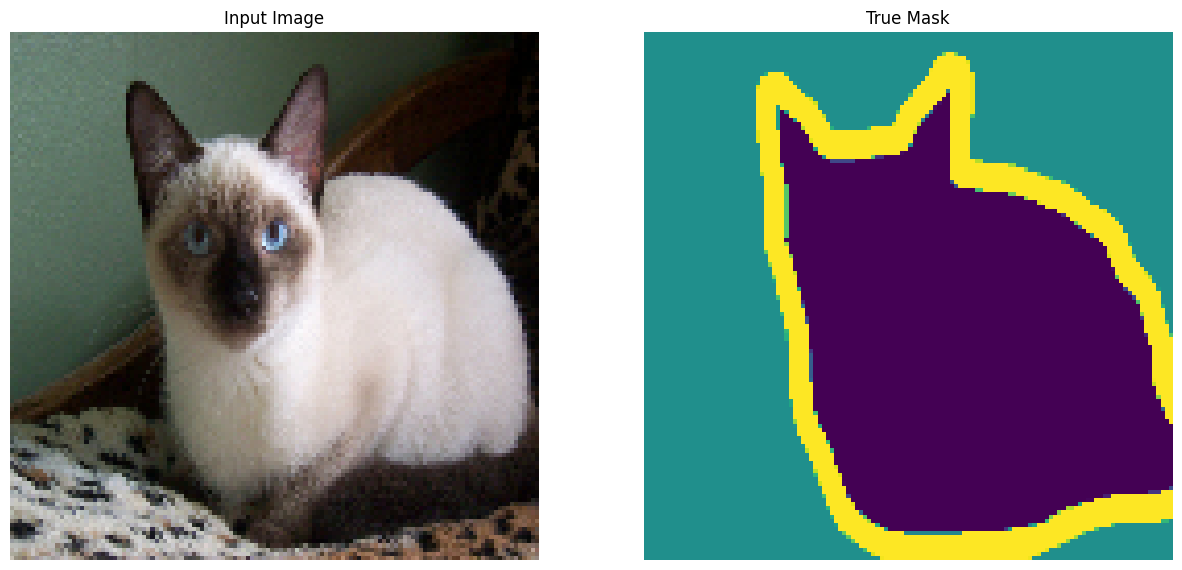

In [47]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(4):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


In [51]:
model = FCNs(128,128,3,s='8')
model.summary()

Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_53       │ [(None, 16, 16,   │ 20,024,384 │ input_layer_20[0… │
│ (Functional)        │ 256), (None, 8,   │            │                   │
│                     │ 8, 512), (None,   │            │                   │
│                     │ 4, 4, 512)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 4, 4,      │ 119,537,6… │ functional_53[0]… │
│ (Sequential)        │ 4096)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 4, 4, 3)   │     12,291 │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 8, 8, 3)   │      1,539 │ functional_53[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_33    │ (None, 8, 8, 3)   │          0 │ conv2d_92[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 8, 8, 3)   │          0 │ conv2d_94[0][0],  │
│                     │                   │            │ up_sampling2d_33… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 16, 16, 3) │        771 │ functional_53[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_35    │ (None, 16, 16, 3) │          0 │ add_9[0][0]       │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 16, 16, 3) │          0 │ conv2d_96[0][0],  │
│                     │                   │            │ up_sampling2d_35… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 16, 16, 3) │         12 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_36    │ (None, 128, 128,  │          0 │ conv2d_97[0][0]   │
│ (UpSampling2D)      │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139,576,661 (532.44 MB)

 Trainable params: 139,576,661 (532.44 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model = unet()

In [53]:
model.summary()

Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_23[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_99 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_98[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_99[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_100 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_101 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_100[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 32, 32,    │          0 │ conv2d_101[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_102[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 16, 16,    │          0 │ conv2d_103[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_10… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_104[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 8, 8, 512) │          0 │ conv2d_105[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_11… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_106[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_37    │ (None, 16, 16,    │          0 │ conv2d_107[0][0]  │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 16, 16,    │  2,097,664 │ up_sampling2d_37

 Total params: 31,033,423 (118.38 MB)

 Trainable params: 31,033,423 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\n 에포크 이후 예측 예시 {}\n'.format(epoch+1))



In [34]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


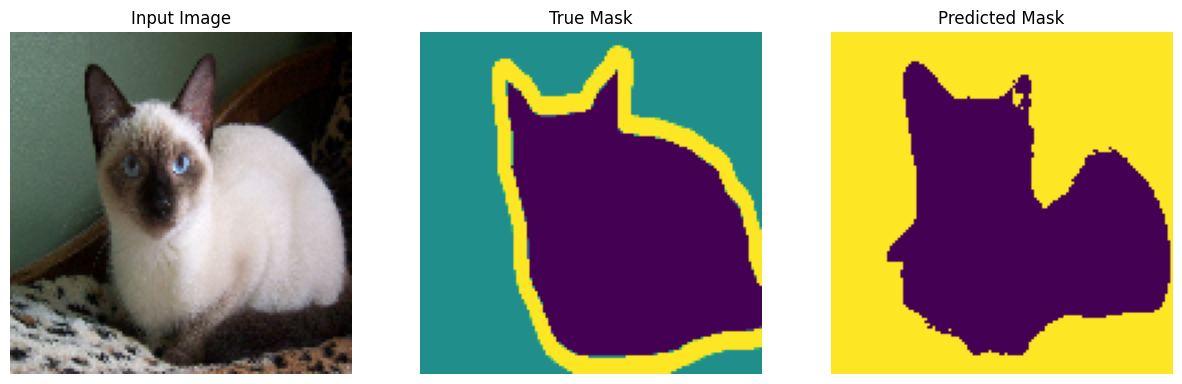


 에포크 이후 예측 예시 6

230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.7985 - loss: 0.6005 - val_accuracy: 0.8115 - val_loss: 0.5719
Epoch 7/20
 54/230 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.7866 - loss: 0.6011

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x796474e1d6d0>>
Traceback (most recent call last):
  File "/home/icuh/anaconda3/envs/tf216/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [55]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


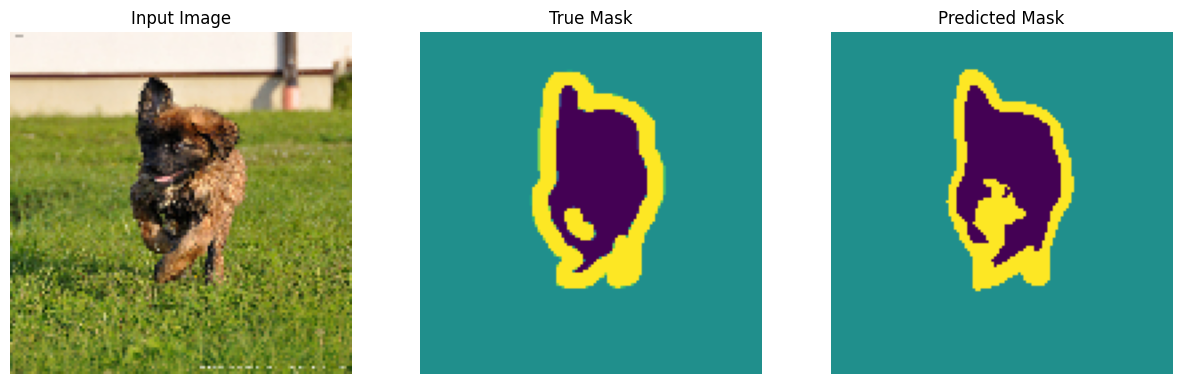

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


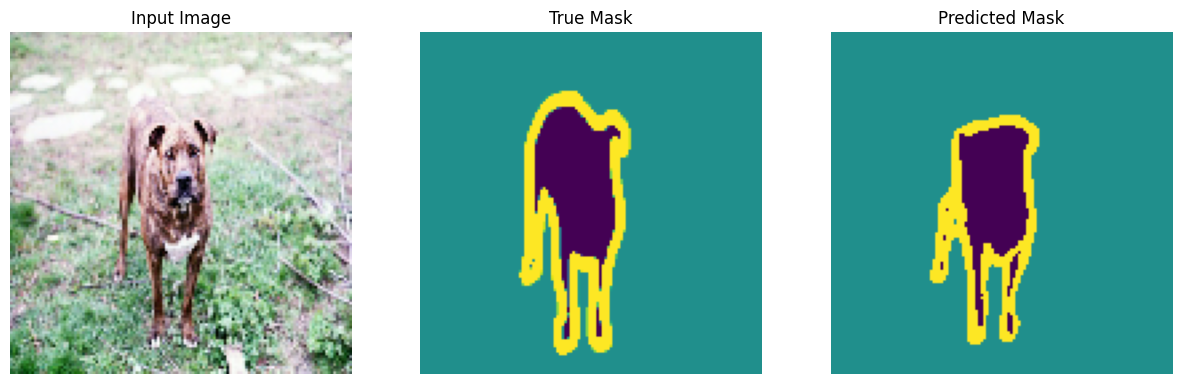

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


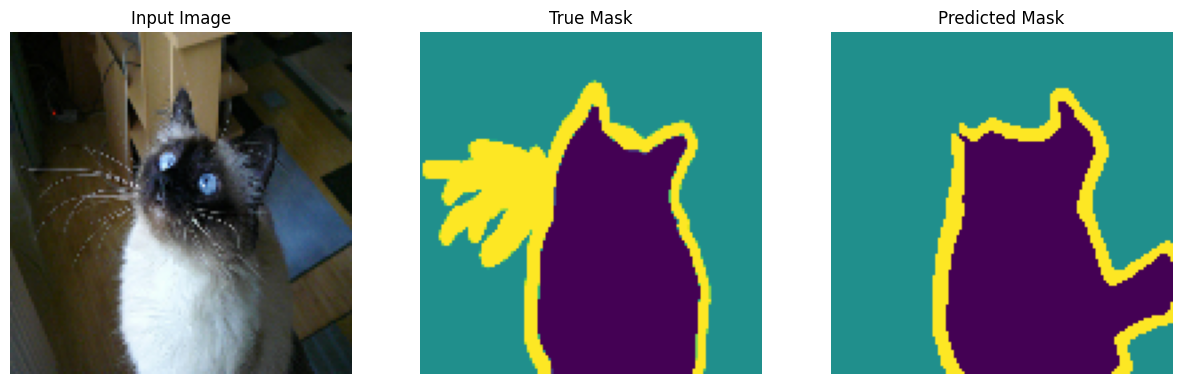

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


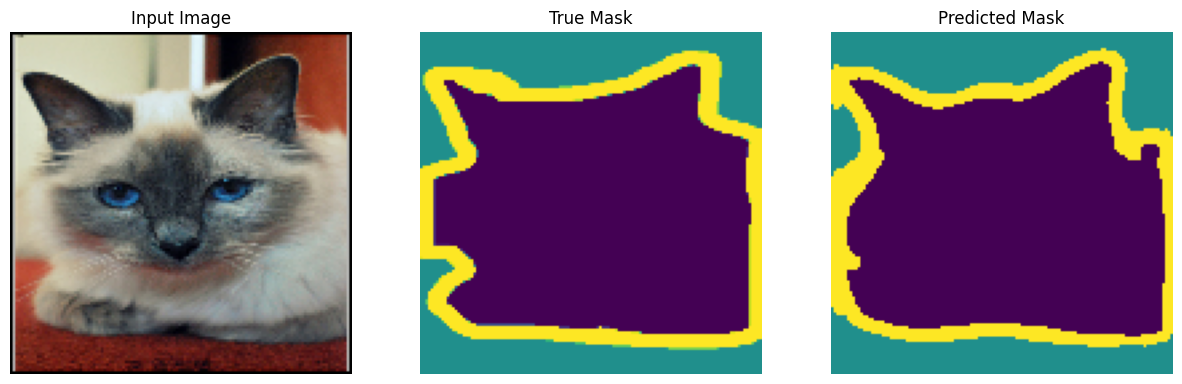

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


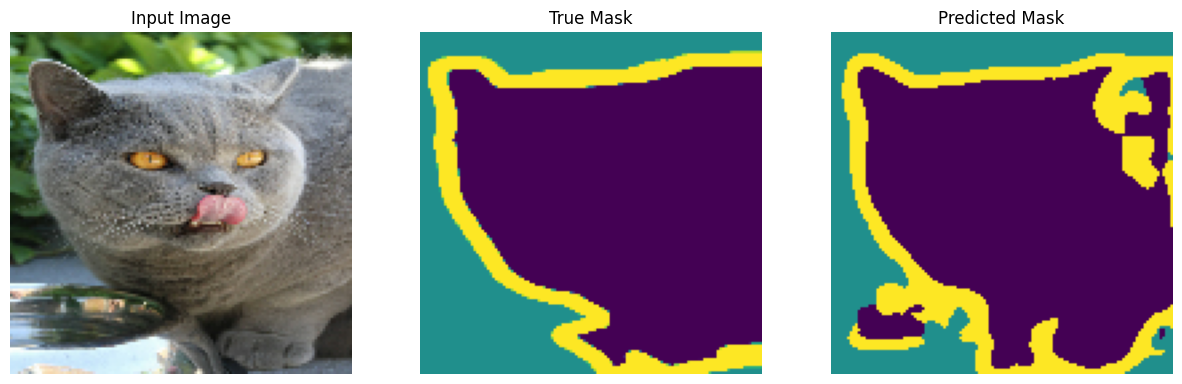

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


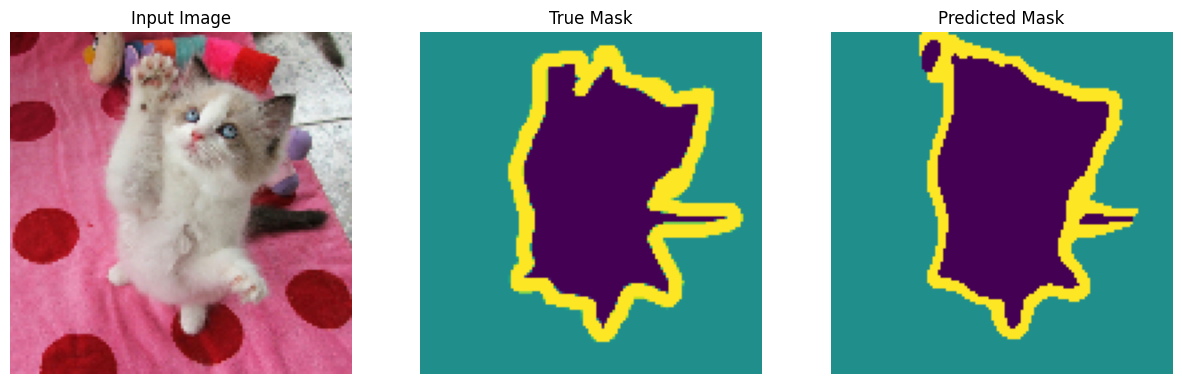

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


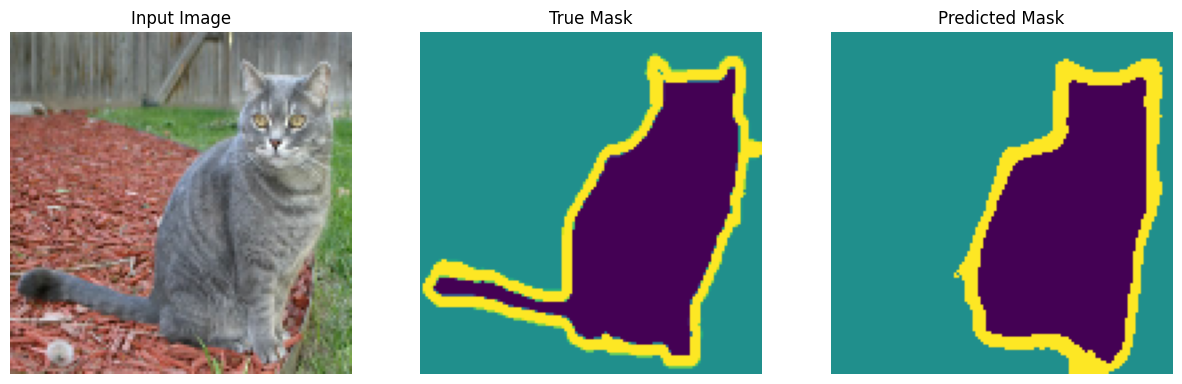

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


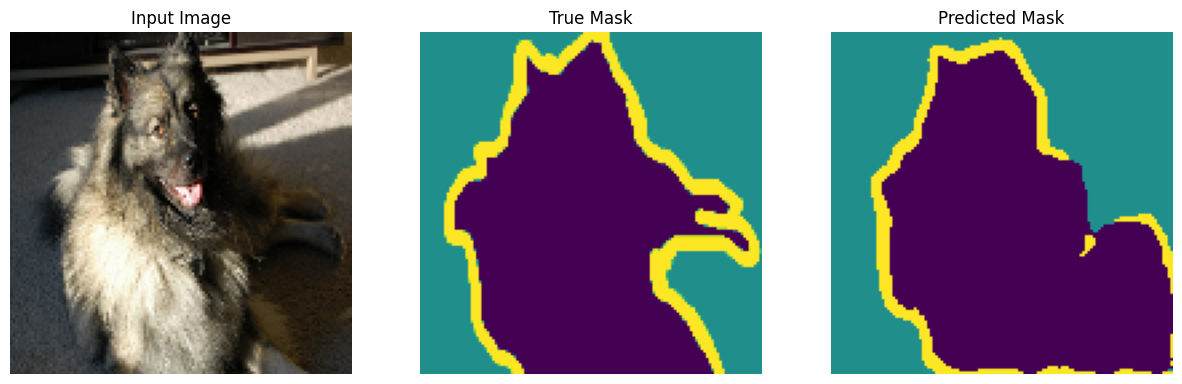

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


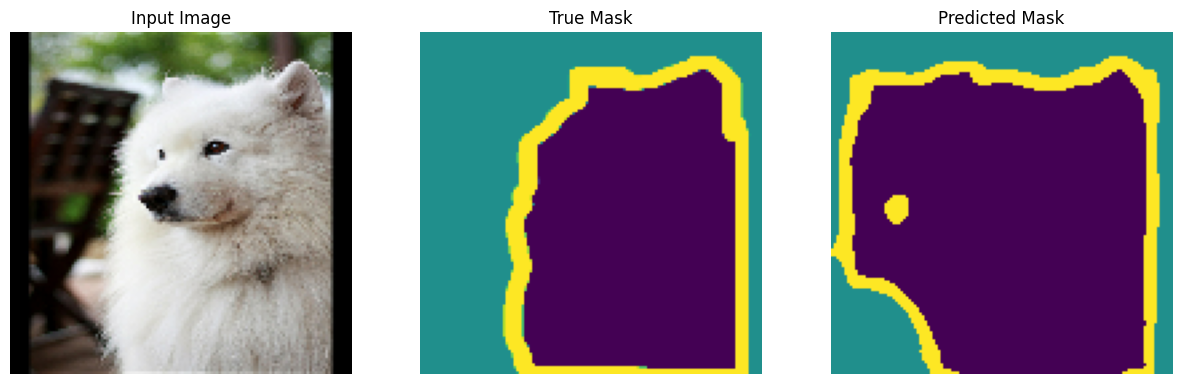

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


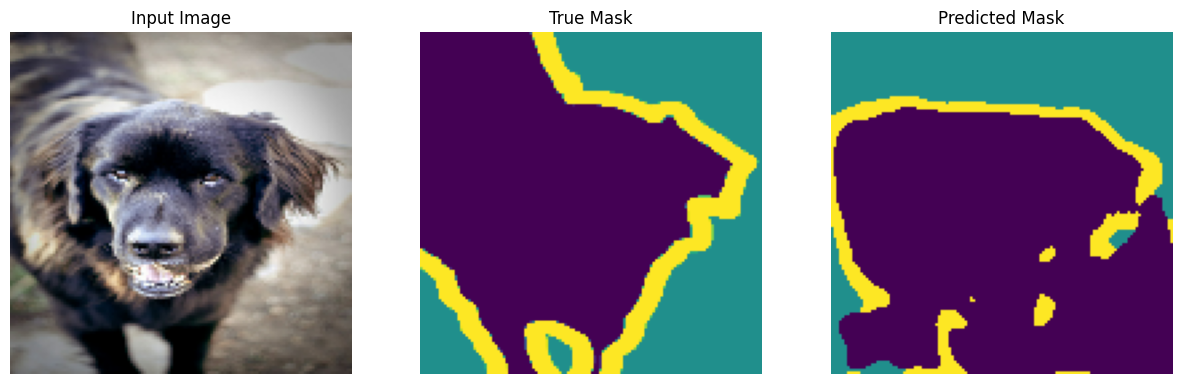

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


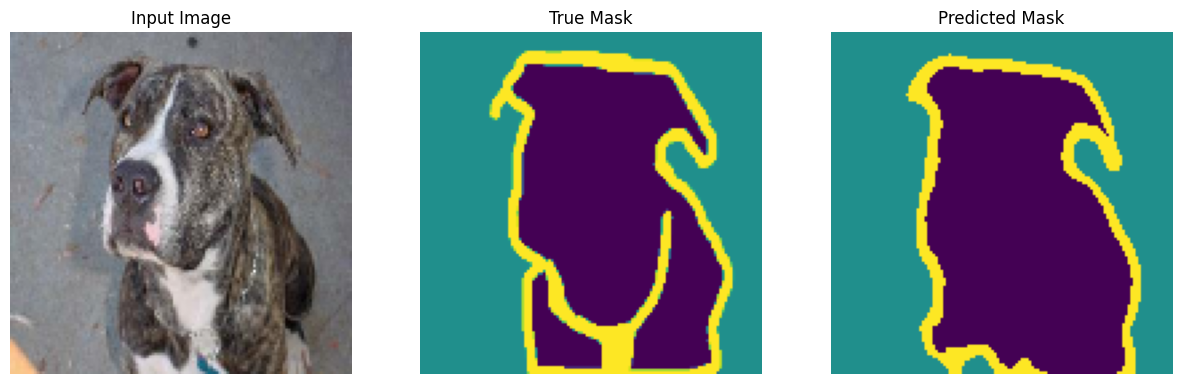

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


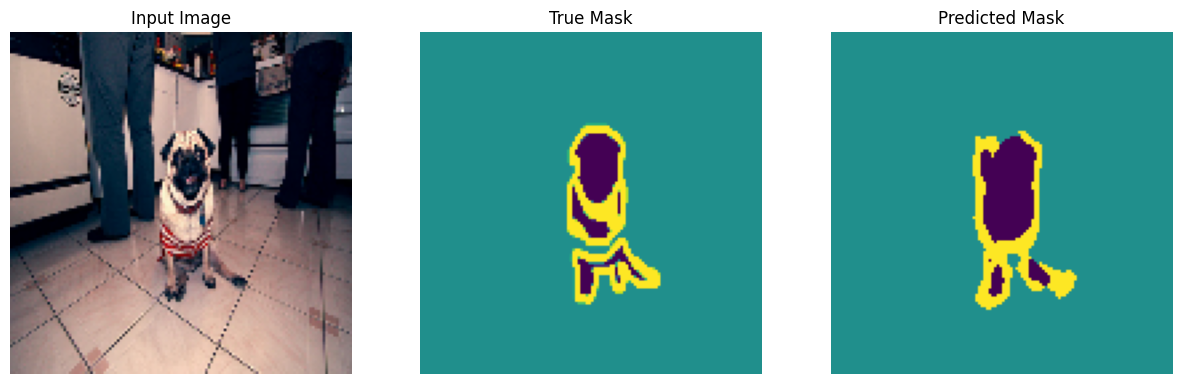

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


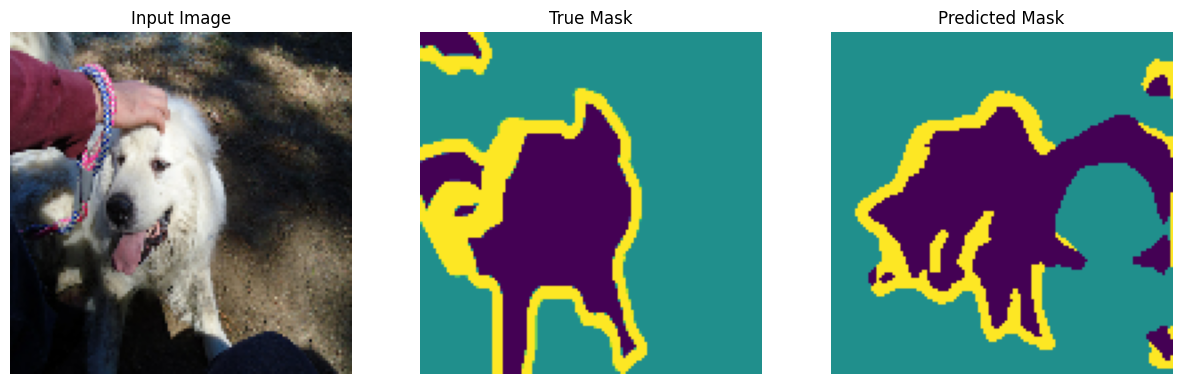

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


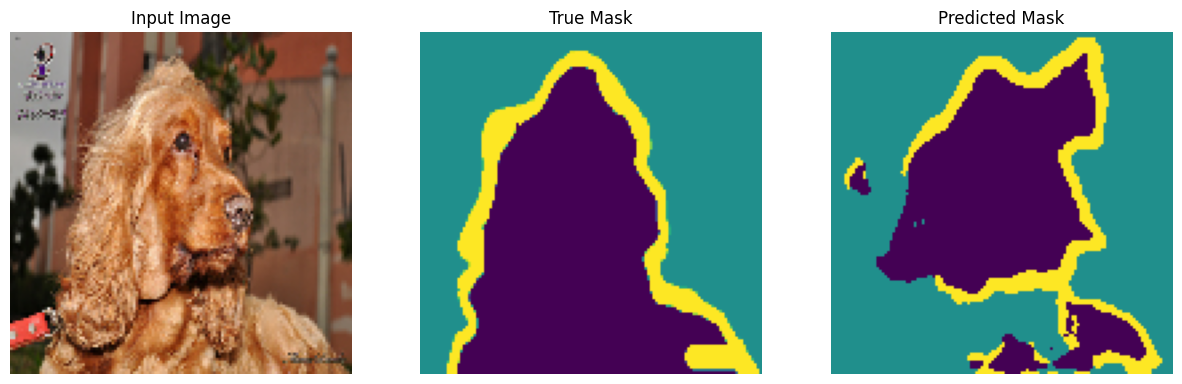

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


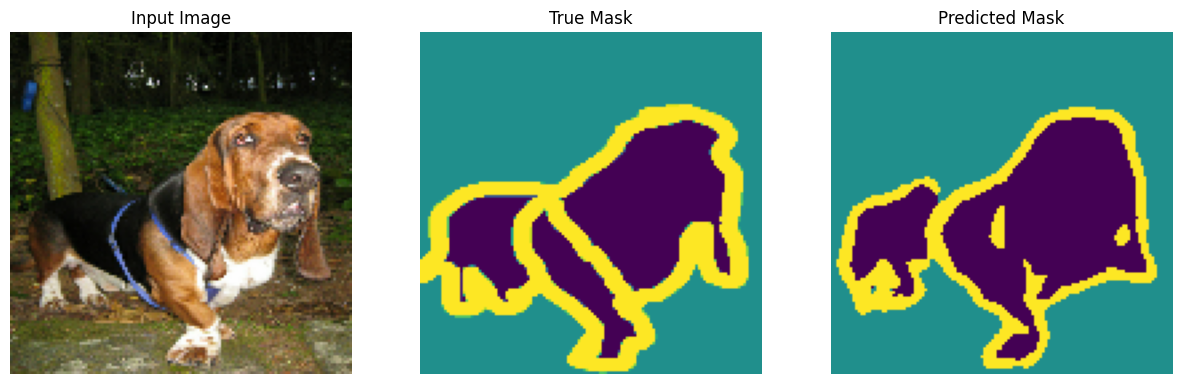

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


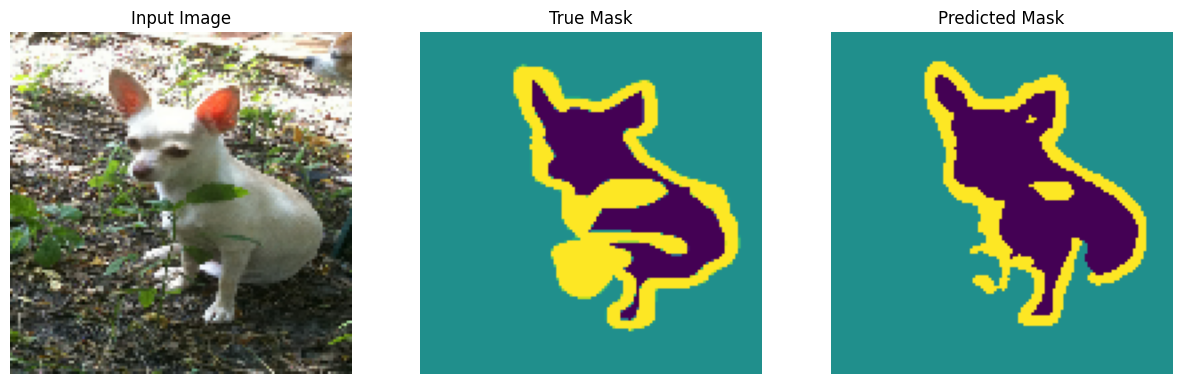

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


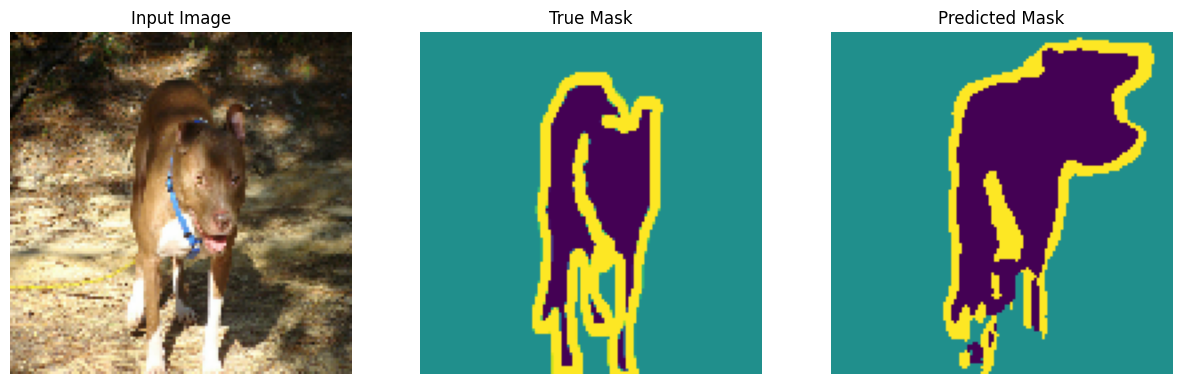

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


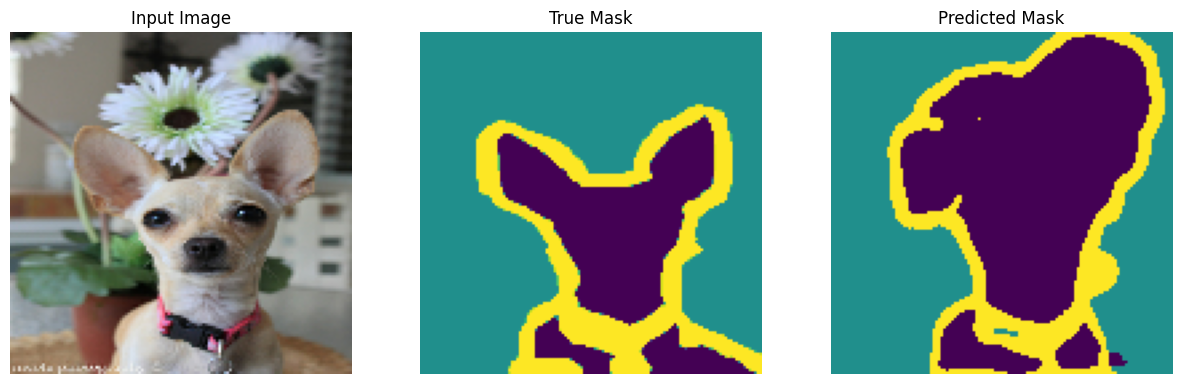

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


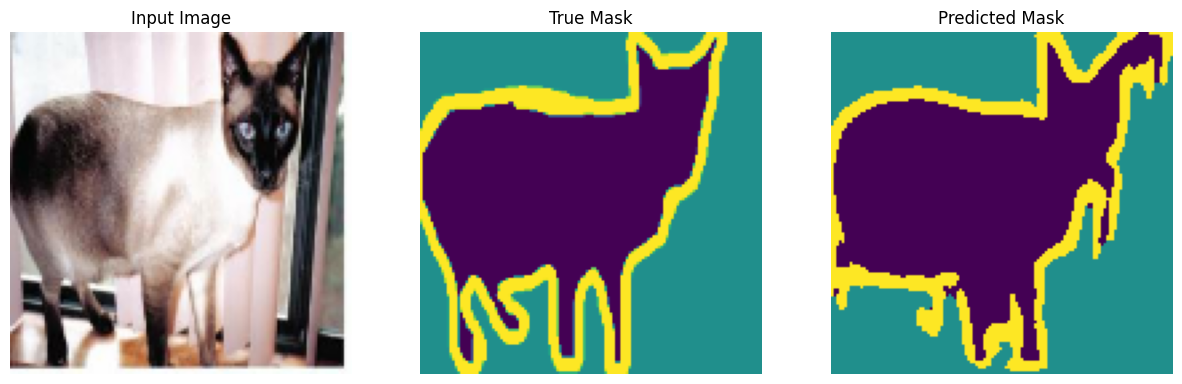

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


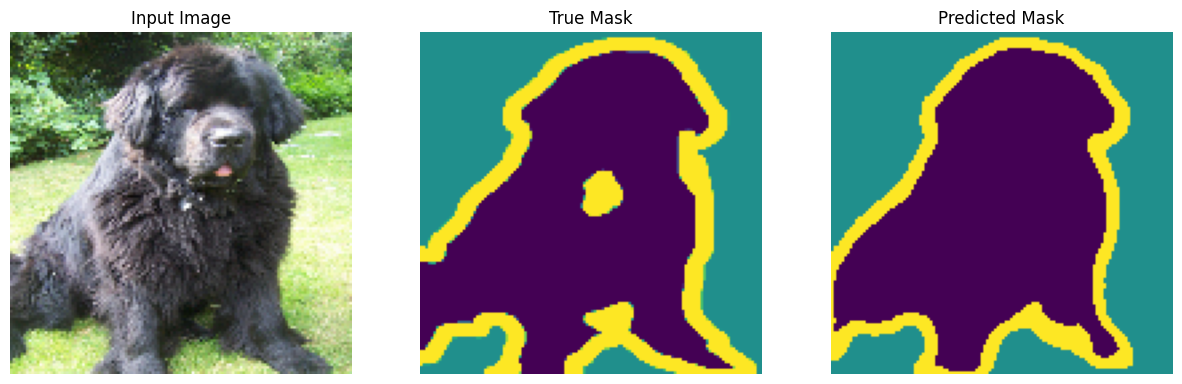

2025-07-17 17:59:19.978972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
show_predictions(test_dataset, 20)